# Notebook configuration

In [1]:
run_number    = 4628
save_plots    = False
plots_format  = "pdf"
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "run{}_corrections.h5".format(run_number)
#copy_corr_to  = "/Users/Gonzalo/github/NEXTdata/XYmaps/"
inputfilename = "/home/brais/Documents/Next/Kr/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =     0, 600
XYrange       =  -198, 198
Rrange        =     0, max(XYrange)
Prange        =  -3.2, 3.2  
Erange_raw    =     0, 15e3
Erange_zcorr  =   5e3, 15e3
Erange_xycorr =   9e3, 14e3
Erange_fit    = 11500, 13500
Qrange        =     0, 10e2
QErange       =     0, Qrange[1]/Erange_xycorr[1]
Frange        =   0.8, 1.5
Urange        =  1e-3, 1.2e-2

S1Erange      =     0, 40
S1Wrange      =     0, 400
S1Hrange      =     0, 10
S2Wrange      =     0, 50
S2Hrange      =     0, 10e3
NSirange      =     0, 30

Zrange_DV     =   545, 555
Zrange_LT     =    50, 520
Zrange_XY     =     0, 520
nX, nY, nR    =    50,  50, 50
x0, y0, r0    =    40, -40, 15 # for lifetime scan

extra_pitches = [( 25,  25),
                 ( 50,  50),
                 ( 75,  75),
                 (100, 100)]

split_sample  = True

In [2]:
Emin_fit      = Erange_fit[0]
Emax_fit      = Erange_fit[1]
Emean_fit     = 0.5*sum(Erange_fit)

# Kr analysis

In [90]:
import os
import shutil
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
from   copy              import copy


import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .kdst_io        as kdstio
import invisible_cities.reco.corrections    as corrf

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import pdf
from invisible_cities.icaro.hst_functions import labels
from invisible_cities.icaro.hst_functions import display_matrix
from invisible_cities.icaro.hst_functions import covariance
from invisible_cities.icaro.hst_functions import resolution
from invisible_cities.icaro.hst_functions import poisson_sigma
from invisible_cities.icaro.hst_functions import gausstext
from invisible_cities.icaro.hst_functions import shift_to_bin_centers
from invisible_cities.icaro.hst_functions import plot_writer
from invisible_cities.icaro.hst_functions import measurement_string


xy_map = dstf.load_xy_corrections("/home/brais/Documents/Next/Correction_maps/run4628_corrections.h5")

pi   = np.pi
save = plot_writer(outputfolder, plots_format) if save_plots else lambda *x: None

Running on  Thu Sep 21 20:37:51 2017


#### General plotting options

In [4]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

# Read data

In [8]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

1827789


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.504810e+09,0,1,150.0,1.628713,7.330867,251400.0,12.271562,1738.578003,...,654462.5,25,403.0625,403.0625,-6.180693,-22.432651,23.268537,-1.839648,11.141517,10.729227
1,5,1.504810e+09,0,1,275.0,3.802718,17.222768,345150.0,10.969375,2321.613525,...,653412.5,23,308.2625,308.2625,-16.337314,40.618310,43.780760,1.953211,11.659206,10.759904
2,6,1.504810e+09,0,1,175.0,2.230152,11.899826,493275.0,8.019000,3005.588135,...,653087.5,23,159.8125,159.8125,-132.351610,3.125162,132.388502,3.117984,9.455723,16.547122
3,7,1.504810e+09,0,2,325.0,7.637844,41.220879,522725.0,6.126250,2353.676025,...,653037.5,20,130.3125,130.3125,21.689926,-125.689443,127.547203,-1.399912,23.105154,18.530561
5,8,1.504810e+09,0,1,225.0,4.044936,21.512648,389725.0,14.284562,1673.607056,...,653162.5,31,263.4375,263.4375,22.665922,-120.972339,123.077418,-1.385579,20.454246,13.668382


In [30]:
print("full dst: ",len(np.unique(full.event)))
print("nS2 = 2 : ",len((full[full.nS2==2])))
print("nS2 = 2 : ",len(np.unique(full[full.nS2==2].event)))
print("nS2 = 2 : ",len(full[full.nS2==2])/2.)
print("full dst: ",len(full[(full.nS2==2)&(full.peak==1)]))
print("full dst: ",len(full[(full.nS2==2)&(full.peak==0)]))
print("full dst: ",len(np.unique(full.event)))
print("full dst: ",len(np.unique(full.event)))

full dst:  1727038
nS2 = 2 :  172458
nS2 = 2 :  90090
nS2 = 2 :  86229.0
full dst:  86796
full dst:  85662
full dst:  1727038
full dst:  1727038


In [169]:
selns2 = [] #np.zeros_like(full.nS2==2)
i = 0

#sel = full[np.fromiter(map(lambda evt: len(full[full.event==evt])==2, np.unique(full.event)),dtype=np.int,count=1000)]
evts = np.unique(full.event[full.nS2==2])
j = 0
for evt in evts:
    if j%1000==0: print(j)
    if len(full[full.event==evt])==2:
        selns2.append(full[full.event==evt])
        
    j += 1
    
    



#sl = np.fromiter(sel,dtype=np.int)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000


In [64]:
s2full = pd.concat(selns2)


In [89]:
print(len(s2full)/2.)

82368.0


In [97]:
three_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + fitf.gauss(x, *args[6:9]) + args[-1]


[  1.08624366e+05   8.69854906e+03   1.99462285e+02   2.92438990e+04
   9.91120589e+03   2.23837548e+02   3.74512508e+04   1.21565898e+04
   1.95058126e+02   5.25602551e+00]
[  1.00495574e+03   1.62010288e+00   1.79950565e+00   1.09260790e+03
   7.15377373e+00   8.04420764e+00   3.61459551e+04   1.86414421e+02
   6.78648273e+01   6.23720775e-01]


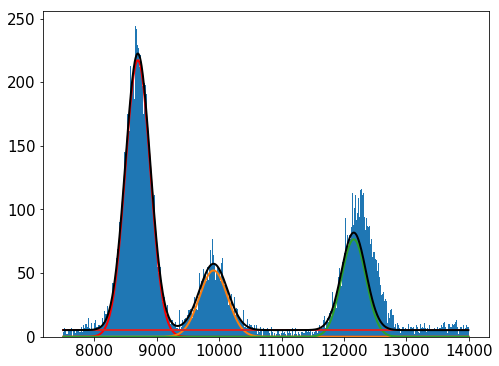

In [145]:
data = s2full
data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
y, x, _ = hist(energy,500,[7.5e3,14e3]);

seed = 1e4,  8500, 300, 1e3, 10000, 500, 2.9e6, 12500,  500, 10
low  =  10,  8000,  50, 1e2,  9000,  50, 2.0e3, 120,  100, 0 
upp  = 1e8,  9000, 900, 1e9, 11000, 500, 1e9, 15000, 9000, 100
f    = fitf.fit(three_gauss, x, y, seed, fit_range=(7.9e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:6]), linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[6:9]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)

#plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)


[ 30304.80443298  12251.32151156    250.26607541]
[ 350.98807436    3.34702593    3.34702599]


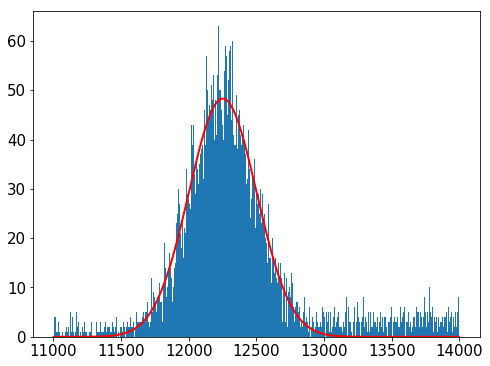

In [138]:
data = s2full
data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
y, x, _ = hist(energy,500,[11e3,14e3]);

seed = 1e4,  12000, 500
low  =  10,  8000,  50  
upp  = 1e8,  9000, 900
f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=(7.9e3,14e3))
print(f.values)
print(f.errors)

xrange = np.linspace(x[0], x[-1],1000)
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)

[-242.07215468  301.00755923] [ 30.19744174   0.93387405]


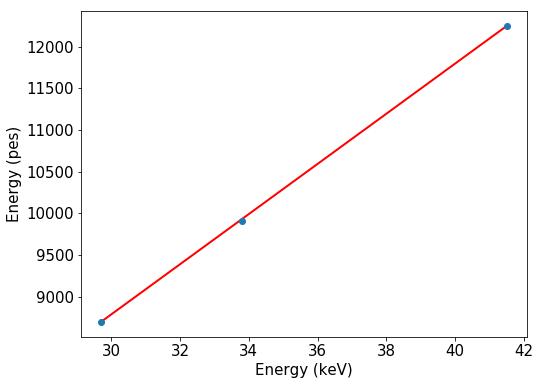

In [156]:
y  = np.array([8.69854757e+03, 9.91121050e+03, 12251.32151156])
ey = np.array([1.62010288e+00, 7.15377373e+00, 3.34702593 ])
x  = np.array([ 29.7         ,  33.8         , 41.5])

plt.errorbar(x, y, ey, fmt = 'o')
plt.xlabel("Energy (keV)")
plt.ylabel("Energy (pes)")

f    = fitf.fit(fitf.polynom, x, y,  [0,0], fit_range=(28,45), sigma=ey)

xrange = np.linspace(x[0], x[-1],1000)
plt.plot(xrange, fitf.polynom(xrange, *f.values), "r-", linewidth=2)

print(f.values, f.errors)

trans = f.values

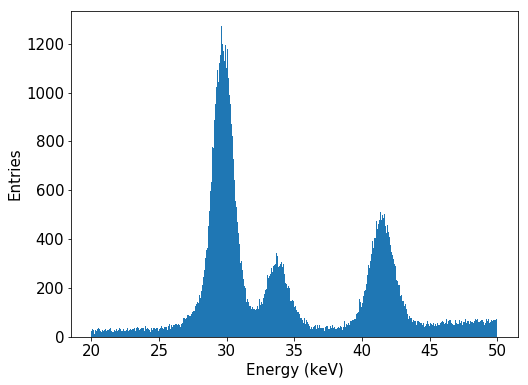

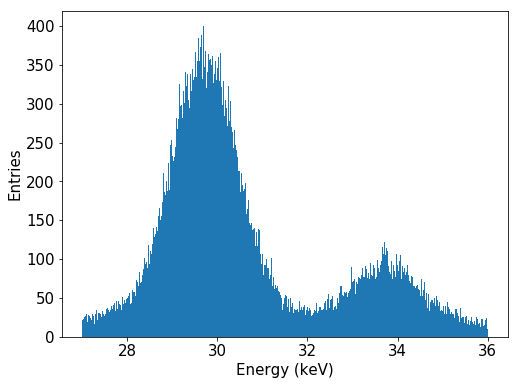

In [166]:
data = s2full
#data = data[data.R<100]
#data = data[data.Z<100]

energy  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value 
energy  = (energy-trans[0])/trans[1]
y, x, _ = hist(energy,500,[20,50])
plt.xlabel("Energy (keV)")
plt.ylabel("Entries")

y, x, _ = hist(energy,500,[27,36])
plt.xlabel("Energy (keV)")
plt.ylabel("Entries")

In [242]:
E1   = []
E2   = []
d    = []
auxE = [0,0]
j = 0
for evt in selns2:
    if j%1000==0: print(j)
    data = evt[evt.peak==0]
    aux  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value    
    d1 = np.array([np.array(data.X)[0], np.array(data.Y)[0],np.array(data.Z)[0]])
    auxE[0] = np.array((aux-trans[0])/trans[1] )[0]
    
    data = evt[evt.peak==1]
    aux  = data.S2e * Zcorr(data.Z.values).value * xy_map(data.X.values, data.Y.values).value
    d2 = np.array([np.array(data.X)[0], np.array(data.Y)[0],np.array(data.Z)[0]])
    auxE[1] = np.array((aux-trans[0])/trans[1] )[0]
    
    d.append(np.sum((d1-d2)**2))
 
    
    E1.append(max(auxE))
    E2.append(min(auxE))
    
    j += 1


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000


In [243]:
d = np.array(d)**0.5
print(d)

[ 13.49032427  51.39581088  81.76089678 ...,   8.52841412  59.89940066
  62.00736974]


In [251]:
import matplotlib.colors as colors

950


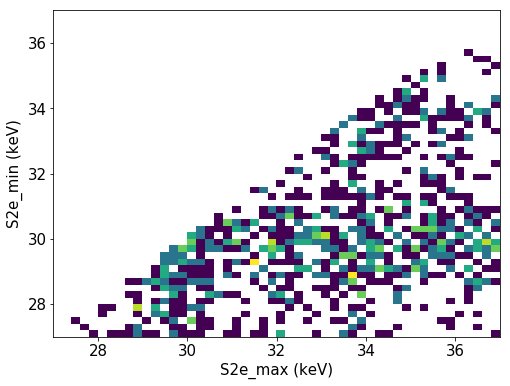

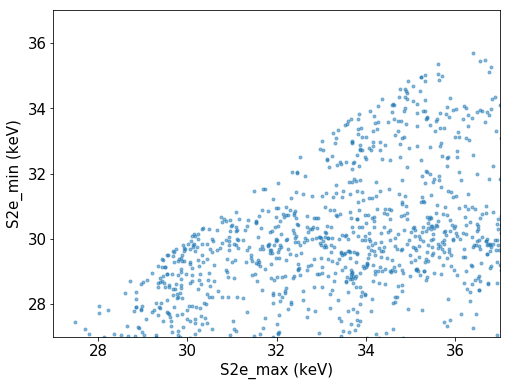

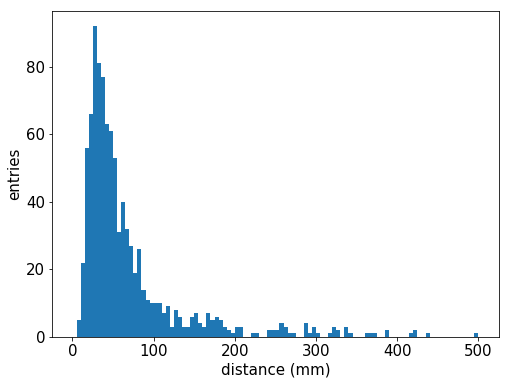

In [254]:
minE, maxE = 27,37

hist2d(np.array(E1),np.array(E2),[50,50],[[minE, maxE],[minE, maxE]], norm=colors.LogNorm());
plt.xlabel("S2e_max (keV)")
plt.ylabel("S2e_min (keV)")


plt.figure()
plt.plot(np.array(E1),np.array(E2), '.',alpha=0.5)
plt.xlim(minE, maxE)
plt.ylim(minE, maxE)
plt.xlabel("S2e_max (keV)")
plt.ylabel("S2e_min (keV)")

selE = np.logical_and(coref.in_range(np.array(E1),minE, maxE), coref.in_range(np.array(E2),minE, maxE)) 

hist(d[selE],100,[0,500])
plt.xlabel("distance (mm)")
plt.ylabel("entries")

print(np.sum(np.logical_and(coref.in_range(np.array(E1),minE, maxE),coref.in_range(np.array(E2),minE, maxE))))